<center><h2><b>Monte Carlo Simulation</b></h2></center>

## Traditional

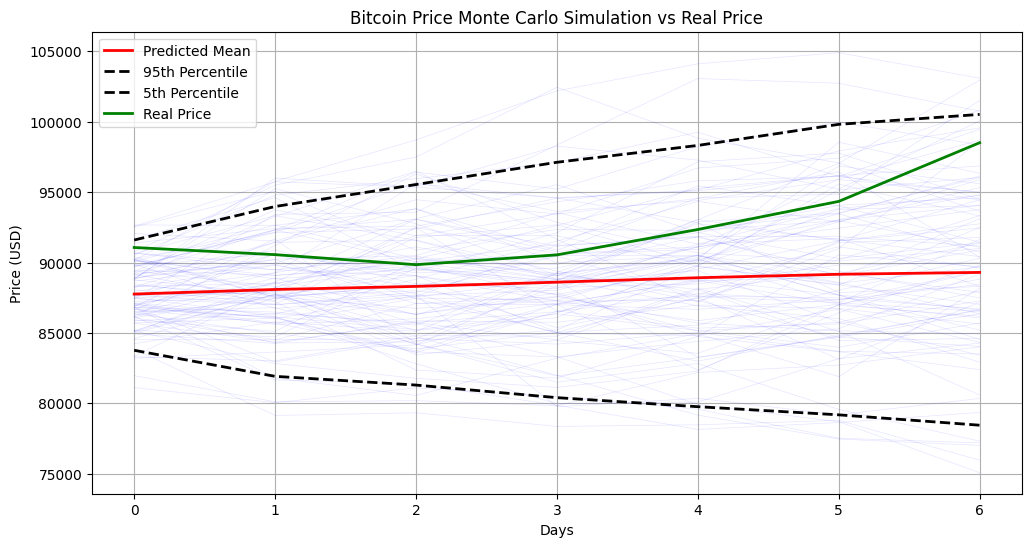

Current Price: $87,250.43
Expected Price (7 days): $89,298.05
95% Confidence Interval:
Lower Bound: $78,450.80
Upper Bound: $100,514.09

Real Final Price: $98,504.73
Prediction Error: $9,206.68
Prediction Error (%): 9.35%


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

compare_with_real_data = True

df_train = pd.read_csv('data/BTC-USD_2023-11-14_2024-11-15_2024-12-15.csv')

df_train['Returns'] = df_train['Close'].pct_change()

mu = df_train['Returns'].mean()
sigma = df_train['Returns'].std()

num_simulations = 1000
num_days = 7
last_price = df_train['Close'].iloc[-1]

simulation_results = np.zeros((num_days, num_simulations))
for sim in range(num_simulations):
    returns = np.random.normal(mu, sigma, num_days)
    price_path = last_price * (1 + returns).cumprod()
    simulation_results[:, sim] = price_path

mean_path = np.mean(simulation_results, axis=1)
lower_bound = np.percentile(simulation_results, 5, axis=1)
upper_bound = np.percentile(simulation_results, 95, axis=1)

plt.figure(figsize=(12, 6))

for i in range(100):
    plt.plot(simulation_results[:, i], 'b-', alpha=0.1, linewidth=0.5)

plt.plot(mean_path, 'r-', label='Predicted Mean', linewidth=2)
plt.plot(upper_bound, 'k--', label='95th Percentile', linewidth=2)
plt.plot(lower_bound, 'k--', label='5th Percentile', linewidth=2)

if compare_with_real_data:
    df_real = pd.read_csv('data/BTC-USD_1mo_2024-12-15.csv')
    plt.plot(df_real['Close'].values[:num_days], 'g-', label='Real Price', linewidth=2)
    plt.title('Bitcoin Price Monte Carlo Simulation vs Real Price')
else:
    plt.title('Bitcoin Price Monte Carlo Simulation')

plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Current Price: ${last_price:,.2f}")
print(f"Expected Price ({num_days} days): ${mean_path[-1]:,.2f}")
print(f"95% Confidence Interval:")
print(f"Lower Bound: ${lower_bound[-1]:,.2f}")
print(f"Upper Bound: ${upper_bound[-1]:,.2f}")

if compare_with_real_data and len(df_real) >= num_days:
    real_final_price = df_real['Close'].iloc[num_days-1]
    print(f"\nReal Final Price: ${real_final_price:,.2f}")
    print(f"Prediction Error: ${abs(mean_path[-1] - real_final_price):,.2f}")
    print(f"Prediction Error (%): {abs(mean_path[-1] - real_final_price) / real_final_price * 100:.2f}%")

## Model Based

c:\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


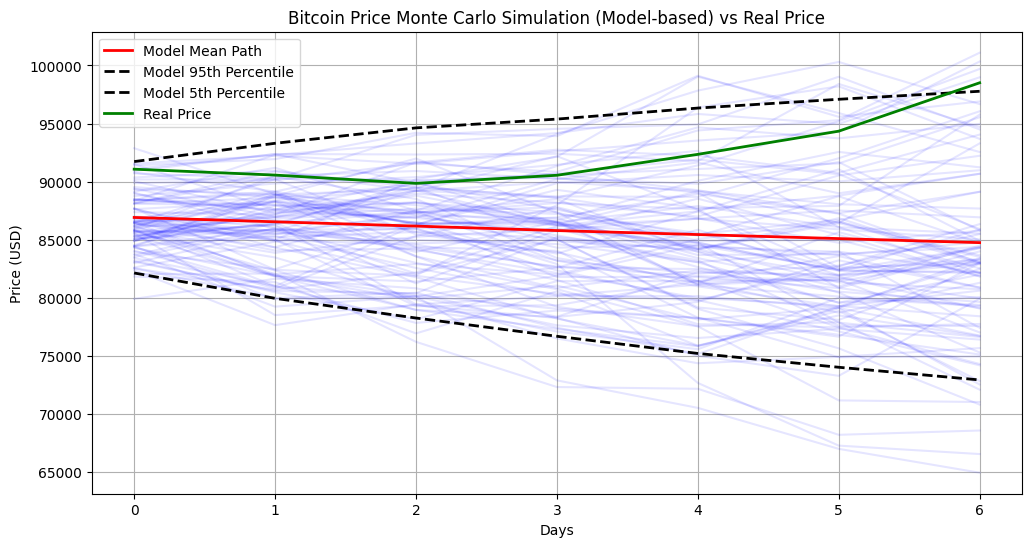

Current Price: $87,250.43

Model-based Monte Carlo Results:
Expected Price (7 days): $84,741.51
95% Confidence Interval:
Lower Bound: $72,920.00
Upper Bound: $97,774.53

Real Final Price: $98,504.73
Prediction Error: $13,763.21
Prediction Error (%): 13.97%


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

compare_with_real_data = True

df = pd.read_csv('data/BTC-USD_2023-11-14_2024-11-15_2024-12-15.csv')

df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)

mu = df['Log_Returns'].mean()
sigma = df['Log_Returns'].std()

def forecast_volatility_gjr(returns):
    model = arch_model(returns.dropna(), vol='Garch', p=1, o=1, q=1)
    results = model.fit(disp='off')
    forecast = results.forecast(horizon=1)
    return np.sqrt(forecast.variance.values[-1][0])

def forecast_drift_xgb(df):
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    X = df[features].values[:-1]
    y = df['Log_Returns'].values[1:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    
    last_data = df[features].values[-1].reshape(1, -1)
    return model.predict(last_data)[0]

sigma_gjr = forecast_volatility_gjr(df['Log_Returns'])
mu_xgb = forecast_drift_xgb(df)

num_simulations = 10000
num_days = 7
last_price = df['Close'].iloc[-1]

simulation_results = np.zeros((num_days, num_simulations))
for sim in range(num_simulations):
    returns = np.random.normal(mu, sigma, num_days)
    price_path = last_price * np.exp(np.cumsum(returns))
    simulation_results[:, sim] = price_path

simulation_results_model = np.zeros((num_days, num_simulations))
for sim in range(num_simulations):
    returns_model = np.random.normal(mu_xgb, sigma_gjr, num_days)
    price_path_model = last_price * np.exp(np.cumsum(returns_model))
    simulation_results_model[:, sim] = price_path_model

mean_path = np.mean(simulation_results, axis=1)
mean_path_model = np.mean(simulation_results_model, axis=1)
lower_bound = np.percentile(simulation_results, 5, axis=1)
upper_bound = np.percentile(simulation_results, 95, axis=1)
lower_bound_model = np.percentile(simulation_results_model, 5, axis=1)
upper_bound_model = np.percentile(simulation_results_model, 95, axis=1)

plt.figure(figsize=(12, 6))
for i in range(100):
    plt.plot(simulation_results_model[:, i], 'b-', alpha=0.1)

plt.plot(mean_path_model, 'r-', label='Model Mean Path', linewidth=2)
plt.plot(upper_bound_model, 'k--', label='Model 95th Percentile', linewidth=2)
plt.plot(lower_bound_model, 'k--', label='Model 5th Percentile', linewidth=2)

if compare_with_real_data:
    df_real = pd.read_csv('data/BTC-USD_1mo_2024-12-15.csv')
    plt.plot(df_real['Close'].values[:num_days], 'g-', label='Real Price', linewidth=2)
    plt.title('Bitcoin Price Monte Carlo Simulation (Model-based) vs Real Price')
else:
    plt.title('Bitcoin Price Monte Carlo Simulation (Model-based)')

plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Current Price: ${last_price:,.2f}")
print("\nModel-based Monte Carlo Results:")
print(f"Expected Price ({num_days} days): ${mean_path_model[-1]:,.2f}")
print(f"95% Confidence Interval:")
print(f"Lower Bound: ${lower_bound_model[-1]:,.2f}")
print(f"Upper Bound: ${upper_bound_model[-1]:,.2f}")

if compare_with_real_data and len(df_real) >= num_days:
    real_final_price = df_real['Close'].iloc[num_days-1]
    print(f"\nReal Final Price: ${real_final_price:,.2f}")
    print(f"Prediction Error: ${abs(mean_path_model[-1] - real_final_price):,.2f}")
    print(f"Prediction Error (%): {abs(mean_path_model[-1] - real_final_price) / real_final_price * 100:.2f}%")
